Импортируем библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import catboost as cb
from datetime import datetime
import seaborn as sns

In [2]:
data_train = pd.read_csv("./data/train.csv")
data_test = pd.read_csv("./data/test.csv")
data_webstat = pd.read_csv("./data/t1_webstat.csv")

is_callcenter - был ли совершен звонок в коллцентр по итогам сессии (нужно предсказать)

order_id - id заказа

create_time - время создания заказа

good_id - id товара

price - цена товара

utm_medium - тип трафика

utm_source - источник трафика

sessionkey_id - id сессии пользователя

category_id - id категории товара

parent_id - id родительской категории для категории товара

root_id - id "базовой" категории товара

rating_value - рейтинг товара

rating_count - число оценок товара

description_length - длина описания товара

goods_qty - число товаров в заказе

model_id - ???

is_moderated - ???

pics_qty - ???

model_create_time - ???

sessionkey_id - id сессии пользователя

date_time - timestamp захода на страницу определенного типа

page_type - тип просмотренной страницы

pageview_number - порядковый номер страницы среди всех страниц, отсортированных по времени посещения внутри сессии

pageview_duration_sec - время просмотра страницы

product_in_sale - ???

In [15]:
data_train["create_time_ts"] = None
data_test["create_time_ts"] = None
data_train["model_create_time_ts"] = None
data_test["model_create_time_ts"] = None

from datetime import datetime
# convert string to date
data_train.create_time_ts = data_train.apply(lambda x: datetime.strptime(x.create_time[:19], '%Y-%m-%d %H:%M:%S'), axis=1)
data_test.create_time_ts = data_test.apply(lambda x: datetime.strptime(x.create_time[:19], '%Y-%m-%d %H:%M:%S'), axis=1)

data_train.loc[~data_train.model_create_time.isna(), "model_create_time_ts"] = data_train.loc[~data_train.model_create_time.isna()].apply(lambda x: datetime.strptime(x.model_create_time[:19], '%Y-%m-%d %H:%M:%S'), axis=1)
data_test.loc[~data_test.model_create_time.isna(), "model_create_time_ts"] = data_test.loc[~data_test.model_create_time.isna()].apply(lambda x: datetime.strptime(x.model_create_time[:19], '%Y-%m-%d %H:%M:%S'), axis=1)

AttributeError: 'Series' object has no attribute 'create_time'

In [4]:
del data_train["create_time"]
del data_train["model_create_time"]
del data_test["create_time"]
del data_test["model_create_time"]

In [5]:
data_train.model_create_time_ts = data_train.model_create_time_ts.fillna(data_train.create_time_ts)
data_test.model_create_time_ts = data_test.model_create_time_ts.fillna(data_test.create_time_ts)

In [123]:
print("Рейтинг товаров, по которым позвонили: ", data_train[data_train["is_callcenter"] == 1]["rating_value"].mean(), 
      ", по которым не звонили", data_train[data_train["is_callcenter"] == 0]["rating_value"].mean())

Рейтинг товаров, по которым позвонили:  1.5399876007439555 , по которым не звонили 1.4771690174232548


In [124]:
print("Длина описания товаров, по которым позвонили: ", data_train[data_train["is_callcenter"] == 1]["description_length"].mean(), 
      ", по которым не звонили", data_train[data_train["is_callcenter"] == 0]["description_length"].mean())

Длина описания товаров, по которым позвонили:  572.92983638373 , по которым не звонили 573.338671921299


In [125]:
print("Представителей 0 класса: 67496, 1 класса: 37099")

Представителей 0 класса: 67496, 1 класса: 37099


In [15]:
A = data_train.groupby(['root_id'])['is_callcenter'].sum().sort_values()
B = data_train.groupby(['root_id'])['is_callcenter'].count().sort_values()
C = A.divide(B).sort_values()

order_id = list(data_train["order_id"].unique())
new_column = list()
for order in order_id:
    root = list(data_train[data_train["order_id"] == order]["root_id"].values)[0]
    new_column.append(C[root])
new_column_test = list()
for order in list(data_test["order_id"].unique()):
    root = list(data_test[data_test["order_id"] == order]["root_id"].values)[0]
    new_column_test.append(C[root])
data_train['root_mean_call'] = new_column
data_test['root_mean_call'] = new_column_test

In [666]:
new_column = list()
for order in range(data_train.shape[0]):
    hour = data_train["create_time_ts"][order].time().hour * 60 + data_train["create_time_ts"][order].time().minute
    new_column.append(hour)
data_train['hour'] = new_column
new_column = list()
for order in range(data_test.shape[0]):
    hour = data_train["create_time_ts"][order].time().hour * 60 + data_train["create_time_ts"][order].time().minute
    new_column.append(hour)
data_test['hour'] = new_column

In [54]:
data_train["utm_source"].fillna(0, inplace=True)
data_test["utm_source"].fillna(0, inplace=True)

In [66]:
data_train["rating_value"].fillna(0, inplace=True)
data_test["rating_value"].fillna(0, inplace=True)

In [75]:
data_train["rating_count"].fillna(0, inplace=True)
data_test["rating_count"].fillna(0, inplace=True)

In [149]:
new_column = list()
for order in range(data_train.shape[0]):
    day = data_train["create_time_ts"][order].date().weekday()
    new_column.append(day)
data_train['day_of_week'] = new_column
new_column = list()
for order in range(data_test.shape[0]):
    day = data_test["create_time_ts"][order].date().weekday()
    new_column.append(day)
data_test['day_of_week'] = new_column

In [654]:
new_column = list()
for order in range(data_train.shape[0]):
    day = data_train["create_time_ts"][order].date().month
    new_column.append(day)
data_train['month'] = new_column
new_column = list()
for order in range(data_test.shape[0]):
    day = data_test["create_time_ts"][order].date().month
    new_column.append(day)
data_test['month'] = new_column

In [1199]:
new_column = list()
for order in range(data_train.shape[0]):
    day = data_train["create_time_ts"][order].date().day
    new_column.append(day)
data_train['day'] = new_column
new_column = list()
for order in range(data_test.shape[0]):
    day = data_test["create_time_ts"][order].date().day
    new_column.append(day)
data_test['day'] = new_column

In [164]:
data_train["life_time"] = (data_train.create_time_ts - data_train.model_create_time_ts).astype('timedelta64[D]')
data_test["life_time"] = (data_test.create_time_ts - data_test.model_create_time_ts).astype('timedelta64[D]')

In [203]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    max_time = data_webstat[data_webstat["sessionkey_id"] == sess_key]["pageview_duration_sec"].max()
    new_column.append(max_time)
data_train['max_time_in_page'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    max_time = data_webstat[data_webstat["sessionkey_id"] == sess_key]["pageview_duration_sec"].max()
    new_column.append(max_time)
data_test['max_time_in_page'] = new_column

In [ ]:
data_train["max_time_in_page"].fillna(-1, inplace=True)
data_test["max_time_in_page"].fillna(-1, inplace=True)

In [263]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = data_webstat[data_webstat["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_page'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = data_webstat[data_webstat["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_page'] = new_column

In [264]:
data_train["count_page"].fillna(0, inplace=True)
data_test["count_page"].fillna(0, inplace=True)

In [229]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = data_webstat[data_webstat["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_time_page'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = data_webstat[data_webstat["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_time_page'] = new_column

In [230]:
data_train["sum_time_page"].fillna(0, inplace=True)
data_test["sum_time_page"].fillna(0, inplace=True)

In [244]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = data_webstat[data_webstat["sessionkey_id"] == sess_key]["pageview_duration_sec"].mean()
    new_column.append(count_page)
data_train['mean_time_page'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = data_webstat[data_webstat["sessionkey_id"] == sess_key]["pageview_duration_sec"].mean()
    new_column.append(count_page)
data_test['mean_time_page'] = new_column

In [245]:
data_train["mean_time_page"].fillna(0, inplace=True)
data_test["mean_time_page"].fillna(0, inplace=True)

In [333]:
data_webstat["page_type"].unique()

array([ 2,  5,  1,  7,  3,  4,  6,  9,  8, 10, 12, 13, 11])

In [319]:
DATA = data_webstat[data_webstat["page_type"] == 1]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_1'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_1'] = new_column

In [320]:
data_train["count_webpage_1"].fillna(0, inplace=True)
data_test["count_webpage_1"].fillna(0, inplace=True)

In [334]:
DATA = data_webstat[data_webstat["page_type"] == 2]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_2'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_2'] = new_column

In [335]:
data_train["count_webpage_2"].fillna(0, inplace=True)
data_test["count_webpage_2"].fillna(0, inplace=True)

In [344]:
DATA = data_webstat[data_webstat["page_type"] == 3]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_3'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_3'] = new_column

In [345]:
data_train["count_webpage_3"].fillna(0, inplace=True)
data_test["count_webpage_3"].fillna(0, inplace=True)

In [358]:
DATA = data_webstat[data_webstat["page_type"] == 4]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_4'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_4'] = new_column

In [359]:
data_train["count_webpage_4"].fillna(0, inplace=True)
data_test["count_webpage_4"].fillna(0, inplace=True)

In [368]:
DATA = data_webstat[data_webstat["page_type"] == 5]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_5'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_5'] = new_column

In [369]:
data_train["count_webpage_5"].fillna(0, inplace=True)
data_test["count_webpage_5"].fillna(0, inplace=True)

In [378]:
DATA = data_webstat[data_webstat["page_type"] == 13]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_13'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_13'] = new_column

In [379]:
data_train["count_webpage_13"].fillna(0, inplace=True)
data_test["count_webpage_13"].fillna(0, inplace=True)

In [407]:
DATA = data_webstat[data_webstat["page_type"] == 6]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_6'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_6'] = new_column

In [408]:
data_train["count_webpage_6"].fillna(0, inplace=True)
data_test["count_webpage_6"].fillna(0, inplace=True)

In [431]:
DATA = data_webstat[data_webstat["page_type"] == 7]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_7'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_7'] = new_column
data_train["count_webpage_7"].fillna(0, inplace=True)
data_test["count_webpage_7"].fillna(0, inplace=True)

In [455]:
DATA = data_webstat[data_webstat["page_type"] == 8]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_8'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_8'] = new_column
data_train["count_webpage_8"].fillna(0, inplace=True)
data_test["count_webpage_8"].fillna(0, inplace=True)

In [471]:
DATA = data_webstat[data_webstat["page_type"] == 9]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_9'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_9'] = new_column
data_train["count_webpage_9"].fillna(0, inplace=True)
data_test["count_webpage_9"].fillna(0, inplace=True)

In [496]:
DATA = data_webstat[data_webstat["page_type"] == 10]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_10'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_10'] = new_column
data_train["count_webpage_10"].fillna(0, inplace=True)
data_test["count_webpage_10"].fillna(0, inplace=True)

In [505]:
DATA = data_webstat[data_webstat["page_type"] == 11]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_11'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_11'] = new_column
data_train["count_webpage_11"].fillna(0, inplace=True)
data_test["count_webpage_11"].fillna(0, inplace=True)

In [521]:
DATA = data_webstat[data_webstat["page_type"] == 12]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_train['count_webpage_12'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key].shape[0]
    new_column.append(count_page)
data_test['count_webpage_12'] = new_column
data_train["count_webpage_12"].fillna(0, inplace=True)
data_test["count_webpage_12"].fillna(0, inplace=True)

In [578]:
# new_column = list()
# for num in range(data_train.shape[0]):
#     sess_key = data_train["sessionkey_id"][num]
#     count_page = data_webstat[data_webstat["sessionkey_id"] == sess_key].sort_values(by = "pageview_number", ascending = False)["page_type"].iloc[0]
#     new_column.append(count_page)
# data_train['last_page'] = new_column
# new_column = list()
# for num in range(data_test.shape[0]):
#     sess_key = data_test["sessionkey_id"][num]
#     count_page = data_webstat[data_webstat["sessionkey_id"] == sess_key].sort_values(by = "pageview_number", ascending = False)["page_type"].iloc[0]
#     new_column.append(count_page)
# data_test['last_page'] = new_column
# data_train["last_page"].fillna(0, inplace=True)
# data_test["last_page"].fillna(0, inplace=True)

In [681]:
DATA = data_webstat[data_webstat["page_type"] == 1]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_1'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_1'] = new_column
data_train["sum_min_1"].fillna(0, inplace=True)
data_test["sum_min_1"].fillna(0, inplace=True)

In [690]:
DATA = data_webstat[data_webstat["page_type"] == 2]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_2'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_2'] = new_column
data_train["sum_min_2"].fillna(0, inplace=True)
data_test["sum_min_2"].fillna(0, inplace=True)

In [700]:
DATA = data_webstat[data_webstat["page_type"] == 3]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_3'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_3'] = new_column
data_train["sum_min_3"].fillna(0, inplace=True)
data_test["sum_min_3"].fillna(0, inplace=True)

In [724]:
DATA = data_webstat[data_webstat["page_type"] == 4]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_4'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_4'] = new_column
data_train["sum_min_4"].fillna(0, inplace=True)
data_test["sum_min_4"].fillna(0, inplace=True)

In [733]:
DATA = data_webstat[data_webstat["page_type"] == 5]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_5'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_5'] = new_column
data_train["sum_min_5"].fillna(0, inplace=True)
data_test["sum_min_5"].fillna(0, inplace=True)

In [742]:
DATA = data_webstat[data_webstat["page_type"] == 6]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_6'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_6'] = new_column
data_train["sum_min_6"].fillna(0, inplace=True)
data_test["sum_min_6"].fillna(0, inplace=True)

DATA = data_webstat[data_webstat["page_type"] == 7]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_7'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_7'] = new_column
data_train["sum_min_7"].fillna(0, inplace=True)
data_test["sum_min_7"].fillna(0, inplace=True)

In [1287]:
DATA = data_webstat[data_webstat["page_type"] == 8]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_8'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_8'] = new_column
data_train["sum_min_8"].fillna(0, inplace=True)
data_test["sum_min_8"].fillna(0, inplace=True)

DATA = data_webstat[data_webstat["page_type"] == 9]
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_train['sum_min_9'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_page = DATA[DATA["sessionkey_id"] == sess_key]["pageview_duration_sec"].sum()
    new_column.append(count_page)
data_test['sum_min_9'] = new_column
data_train["sum_min_9"].fillna(0, inplace=True)
data_test["sum_min_9"].fillna(0, inplace=True)

In [952]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_second = (data_train[data_train["sessionkey_id"] == sess_key]["create_time_ts"].max() - data_webstat[data_webstat["sessionkey_id"] == sess_key]['time'].max()).seconds
    new_column.append(count_second)
data_train['second_order_last'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_second = (data_test[data_test["sessionkey_id"] == sess_key]["create_time_ts"].max() - data_webstat[data_webstat["sessionkey_id"] == sess_key]['time'].max()).seconds
    new_column.append(count_second)
data_test['second_order_last'] = new_column

In [1061]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    count_second = (data_webstat[data_webstat["sessionkey_id"] == sess_key]['time'].max() - data_webstat[data_webstat["sessionkey_id"] == sess_key]['time'].min()).seconds
    new_column.append(count_second)
data_train['first_last_time'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    count_second = (data_webstat[data_webstat["sessionkey_id"] == sess_key]['time'].max() - data_webstat[data_webstat["sessionkey_id"] == sess_key]['time'].min()).seconds
    new_column.append(count_second)
data_test['first_last_time'] = new_column

In [1806]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    max_time = list(data_train[data_train["sessionkey_id"] == sess_key]["first_last_time"])[0] - list(data_train[data_train["sessionkey_id"] == sess_key]["sum_time_page"])[0]
    new_column.append(max_time)
data_train['non_session_time'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    max_time = list(data_test[data_test["sessionkey_id"] == sess_key]["first_last_time"])[0] - list(data_test[data_test["sessionkey_id"] == sess_key]["sum_time_page"])[0]
    new_column.append(max_time)
data_test['non_session_time'] = new_column

In [1807]:
data_train

,order_id,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,model_id,...,sum_min_4,sum_min_5,sum_min_6,sum_min_7,second_order_last,first_last_time,day,sum_min_8,sum_min_9,non_session_time
0,1269921,9896348,753,5,8.0,123777004,139,133,124,123517,...,0.0,0.0,0.0,0.0,545.0,0.0,26,0.0,0.0,0.0
1,1270034,9896348,753,1,2.0,123781654,139,133,124,123517,...,0.0,15.0,0.0,0.0,86272.0,4237.0,26,33.0,0.0,406.0
2,1268272,9896348,753,2,3.0,123591002,139,133,124,123517,...,0.0,15.0,0.0,0.0,76.0,370.0,25,72.0,0.0,0.0
3,1270544,9896348,753,1,1.0,123832302,139,133,124,123517,...,0.0,0.0,0.0,0.0,85569.0,1926.0,26,0.0,0.0,0.0
4,1270970,9896348,753,3,56.0,123881603,139,133,124,123517,...,0.0,0.0,47.0,0.0,233.0,447.0,26,0.0,0.0,353.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104590,1250981,68657110,1497,4,1.0,121795335,2873,1229,1183,35231362,...,1614.0,0.0,0.0,0.0,83726.0,3124.0,16,0.0,0.0,15.0
104591,1173775,60391507,1354,1,2.0,114277105,2873,1229,1183,35231362,...,0.0,0.0,0.0,0.0,41690.0,1046.0,8,34.0,0.0,436.0
104592,1180920,66971400,1452,2,0.0,114972131,2873,1229,1183,35231362,...,0.0,0.0,39.0,0.0,86349.0,2276.0,12,0.0,0.0,674.0
104593,1177882,60391498,1433,4,2.0,114672813,2873,1229,1183,35231362,...,0.0,19.0,0.0,0.0,305.0,1361.0,10,0.0,0.0,0.0


In [2]:
data_train = pd.read_csv("./data_train_new.csv")
data_test = pd.read_csv("./data_test_new.csv")
data_webstat = pd.read_csv("./data/t1_webstat.csv")

In [7]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    max_time = list(data_train[data_train["sessionkey_id"] == sess_key]["first_last_time"])[0] - list(data_train[data_train["sessionkey_id"] == sess_key]["sum_time_page"])[0]
    new_column.append(max_time)
data_train['non_session_time'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    max_time = list(data_test[data_test["sessionkey_id"] == sess_key]["first_last_time"])[0] - list(data_test[data_test["sessionkey_id"] == sess_key]["sum_time_page"])[0]
    new_column.append(max_time)
data_test['non_session_time'] = new_column

In [38]:
data_webstat

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
0,122243978,1975-12-18 14:52:38.130,2,28,53.0,1773.0,NaN,NaN,NaN,NaN
1,122243978,1975-12-18 15:02:32.403,5,36,163.0,NaN,NaN,NaN,NaN,NaN
2,122243978,1975-12-18 15:08:11.147,5,40,156.0,NaN,NaN,NaN,NaN,NaN
3,122243992,1975-12-18 14:23:33.177,1,4,565.0,3973.0,26706175.0,45171119.0,8436.0,1.0
4,122243992,1975-12-18 14:32:58.763,1,5,73.0,3973.0,17297250.0,65195750.0,6624.0,1.0
...,...,...,...,...,...,...,...,...,...,...
3334238,119215415,1975-12-03 14:45:42.320,1,2,NaN,141.0,856955.0,26681969.0,3467.0,1.0
3334239,119215471,1975-12-03 14:45:30.520,6,5,21.0,NaN,NaN,NaN,NaN,NaN
3334240,119215471,1975-12-03 14:50:11.470,6,8,16.0,NaN,NaN,NaN,NaN,NaN
3334241,119215471,1975-12-03 14:50:56.133,6,10,7.0,NaN,NaN,NaN,NaN,NaN


In [4]:
data_webstat = data_webstat.sort_values(by='date_time')

In [173]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    data_s = data_webstat[data_webstat["sessionkey_id"] == sess_key]["page_type"]
    if data_s.shape[0] > 0:
        max_time = data_s.iloc[-1]
    else:
        max_time = 0
    new_column.append(max_time)
data_train['last_page_type'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    data_s = data_webstat[data_webstat["sessionkey_id"] == sess_key]["page_type"]
    if data_s.shape[0] > 0:
        max_time = data_s.iloc[-1]
    else:
        max_time = 0
    new_column.append(max_time)
data_test['last_page_type'] = new_column

In [17]:
new_column = list()
for num in range(data_train.shape[0]):
    sess_key = data_train["sessionkey_id"][num]
    table = data_webstat[data_webstat["sessionkey_id"] == sess_key]
    if table.shape[0] > 0:
        max_time = int(pd.isna(table["pageview_duration_sec"].iloc[-1]))
    else:
        max_time = -1
    new_column.append(max_time)
data_train['is_nan_last_time'] = new_column
new_column = list()
for num in range(data_test.shape[0]):
    sess_key = data_test["sessionkey_id"][num]
    table = data_webstat[data_webstat["sessionkey_id"] == sess_key]
    if table.shape[0] > 0:
        max_time = int(pd.isna(table["pageview_duration_sec"].iloc[-1]))
    else:
        max_time = -1
    new_column.append(max_time)
data_test['is_nan_last_time'] = new_column

In [18]:
data_train.columns

Index(['order_id', 'good_id', 'price', 'utm_medium', 'utm_source',
       'sessionkey_id', 'category_id', 'parent_id', 'root_id', 'model_id',
       'is_moderated', 'rating_value', 'rating_count', 'description_length',
       'goods_qty', 'pics_qty', 'is_callcenter', 'create_time_ts',
       'model_create_time_ts', 'root_mean_call', 'hour', 'day_of_week',
       'life_time', 'max_time_in_page', 'count_page', 'sum_time_page',
       'mean_time_page', 'count_webpage_1', 'count_webpage_2',
       'count_webpage_3', 'count_webpage_4', 'count_webpage_5',
       'count_webpage_13', 'count_webpage_6', 'count_webpage_7',
       'count_webpage_8', 'count_webpage_9', 'count_webpage_10',
       'count_webpage_11', 'count_webpage_12', 'month', 'sum_min_1',
       'sum_min_2', 'sum_min_3', 'sum_min_4', 'sum_min_5', 'sum_min_6',
       'sum_min_7', 'second_order_last', 'first_last_time', 'day',
       'non_session_time', 'last_page_type', 'is_nan_last_time'],
      dtype='object')

In [19]:
data_train

,order_id,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,model_id,...,sum_min_4,sum_min_5,sum_min_6,sum_min_7,second_order_last,first_last_time,day,non_session_time,last_page_type,is_nan_last_time
0,1269921,9896348,753,5,8.0,123777004,139,133,124,123517,...,0.0,0.0,0.0,0.0,545.0,0.0,26,0.0,1,1
1,1270034,9896348,753,1,2.0,123781654,139,133,124,123517,...,0.0,15.0,0.0,0.0,86272.0,4237.0,26,406.0,4,1
2,1268272,9896348,753,2,3.0,123591002,139,133,124,123517,...,0.0,15.0,0.0,0.0,76.0,370.0,25,0.0,1,1
3,1270544,9896348,753,1,1.0,123832302,139,133,124,123517,...,0.0,0.0,0.0,0.0,85569.0,1926.0,26,0.0,2,1
4,1270970,9896348,753,3,56.0,123881603,139,133,124,123517,...,0.0,0.0,47.0,0.0,233.0,447.0,26,353.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104590,1250981,68657110,1497,4,1.0,121795335,2873,1229,1183,35231362,...,1614.0,0.0,0.0,0.0,83726.0,3124.0,16,15.0,1,1
104591,1173775,60391507,1354,1,2.0,114277105,2873,1229,1183,35231362,...,0.0,0.0,0.0,0.0,41690.0,1046.0,8,436.0,2,1
104592,1180920,66971400,1452,2,0.0,114972131,2873,1229,1183,35231362,...,0.0,0.0,39.0,0.0,86349.0,2276.0,12,674.0,6,0
104593,1177882,60391498,1433,4,2.0,114672813,2873,1229,1183,35231362,...,0.0,19.0,0.0,0.0,305.0,1361.0,10,0.0,1,1


In [20]:
features = ['good_id', 'price', 'utm_medium', 'utm_source', 'category_id', 'parent_id', 'root_id', 'model_id',
       'is_moderated', 'rating_value', 'rating_count', 'description_length',
       'goods_qty', 'pics_qty',
       'model_create_time_ts', 'root_mean_call', 'hour', 'day_of_week',
       'life_time', 'max_time_in_page', 'count_page', 'sum_time_page',
       'mean_time_page', 'count_webpage_1', 'count_webpage_2',
       'count_webpage_3', 'count_webpage_4', 'count_webpage_5',
       'count_webpage_13', 'count_webpage_6', 'count_webpage_7',
       'count_webpage_8', 'count_webpage_9', 'count_webpage_10',
       'count_webpage_11', 'count_webpage_12', 'month', 'sum_min_1',
       'sum_min_2', 'sum_min_3', 'sum_min_4', 'sum_min_5', 'sum_min_6',
       'sum_min_7', 'second_order_last', 'first_last_time', 'day', 'non_session_time', 'last_page_type', "is_nan_last_time"
]

# ОБУЧЕНИЕ (TEST)

In [21]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from catboost import cv
from catboost import Pool

In [22]:
X_train_val, X_test, y_train_val, y_test = train_test_split(data_train[features], data_train["is_callcenter"], test_size=0.15, stratify=data_train["is_callcenter"])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, stratify = y_train_val)

In [23]:
model = CatBoostClassifier(eval_metric = 'AUC', class_weights = [0.35, 0.65], verbose = 100)

In [24]:
model.fit(X_train, y_train,eval_set=(X_val, y_val), use_best_model=True)

Learning rate set to 0.092227
0:	test: 0.9404577	best: 0.9404577 (0)	total: 72.3ms	remaining: 1m 12s
100:	test: 0.9639026	best: 0.9639182 (98)	total: 1.41s	remaining: 12.6s
200:	test: 0.9649900	best: 0.9649972 (197)	total: 2.57s	remaining: 10.2s
300:	test: 0.9653179	best: 0.9653747 (289)	total: 3.76s	remaining: 8.74s
400:	test: 0.9655416	best: 0.9655702 (398)	total: 4.93s	remaining: 7.37s
500:	test: 0.9657383	best: 0.9657402 (498)	total: 6.11s	remaining: 6.09s
600:	test: 0.9656248	best: 0.9657684 (520)	total: 7.27s	remaining: 4.83s
700:	test: 0.9655967	best: 0.9657684 (520)	total: 8.56s	remaining: 3.65s
800:	test: 0.9655446	best: 0.9657684 (520)	total: 9.88s	remaining: 2.46s
900:	test: 0.9654050	best: 0.9657684 (520)	total: 11.1s	remaining: 1.22s
999:	test: 0.9654329	best: 0.9657684 (520)	total: 12.3s	remaining: 0us

bestTest = 0.9657683513
bestIteration = 520

Shrink model to first 521 iterations.


In [25]:
predictions = model.predict_proba(X_test[features])

In [26]:
predictions

array([[0.61175718, 0.38824282],
       [0.99838686, 0.00161314],
       [0.46565067, 0.53434933],
       ...,
       [0.91034161, 0.08965839],
       [0.00560546, 0.99439454],
       [0.99000836, 0.00999164]])

In [27]:
ans = list()
for element in predictions:
    ans.append(element[1])

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, ans)

0.9662797333422071

In [29]:
model.get_feature_importance()

array([8.62097714e-01, 1.47628550e+00, 1.49536641e+00, 9.73146470e-01,
       4.89027258e-01, 5.36026550e-01, 1.73394095e-01, 5.45837012e-01,
       3.44540143e-02, 1.58993775e-01, 2.37691648e-01, 6.04128465e-01,
       3.66706354e-01, 3.75705814e-01, 0.00000000e+00, 6.87059009e-01,
       4.34053132e+00, 3.97239491e+00, 5.21934071e-01, 2.86895041e+00,
       5.47217831e-01, 1.12320840e+00, 1.53090326e+00, 3.74431721e-01,
       4.75002838e-01, 1.89039323e+00, 1.27987906e-01, 1.38022059e-01,
       2.86538355e-03, 4.48643024e+00, 1.64576057e-01, 2.87010060e-01,
       1.51949050e-01, 8.50014576e-02, 2.22295315e-02, 2.22912084e-02,
       3.70547862e-01, 9.20808719e-01, 6.76718750e-01, 3.13632197e+00,
       2.08168631e-01, 2.48267901e-01, 3.31461517e-01, 3.41036442e-01,
       3.38221781e+01, 1.06014665e+00, 6.55495472e-01, 8.35315228e+00,
       7.81212081e-01, 1.69452326e+01])

[14 28 34 35  8 33 26 27 32  9 30  6 40 10 41 31 42 43 12 36 23 13 24  4
 18  5  7 20 11 46 38 15 48  0 37  3 45 21  1  2 22 25 19 39 17 16 29 47
 49 44]


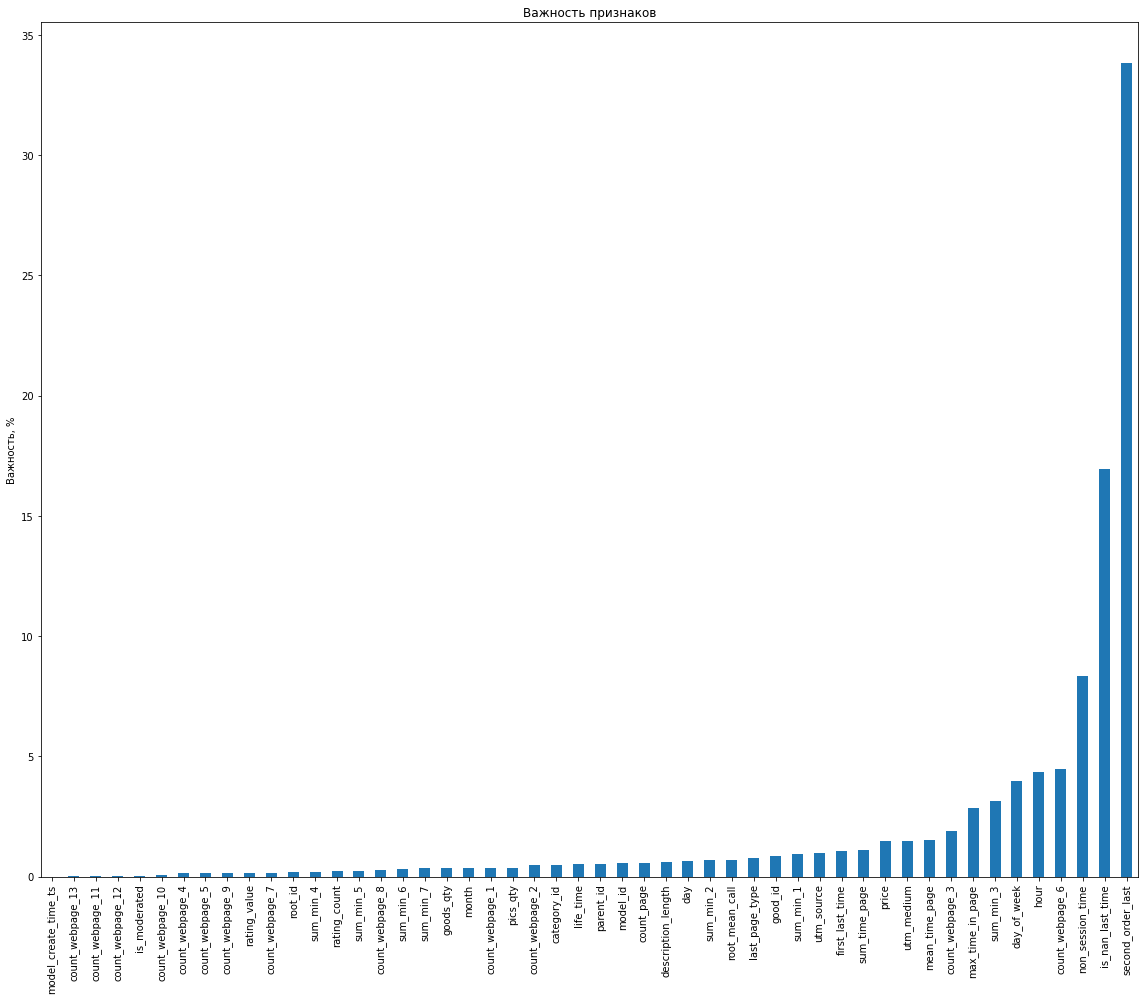

In [30]:
indices = model.get_feature_importance().argsort()
print(indices)
cat_iris_imp = pd.Series(np.array(model.get_feature_importance())[indices],
                         np.array(features)[indices])
fig, ax = plt.subplots(figsize=(16,14))
cat_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

In [31]:
np.array(features)[indices]

array(['model_create_time_ts', 'count_webpage_13', 'count_webpage_11',
       'count_webpage_12', 'is_moderated', 'count_webpage_10',
       'count_webpage_4', 'count_webpage_5', 'count_webpage_9',
       'rating_value', 'count_webpage_7', 'root_id', 'sum_min_4',
       'rating_count', 'sum_min_5', 'count_webpage_8', 'sum_min_6',
       'sum_min_7', 'goods_qty', 'month', 'count_webpage_1', 'pics_qty',
       'count_webpage_2', 'category_id', 'life_time', 'parent_id',
       'model_id', 'count_page', 'description_length', 'day', 'sum_min_2',
       'root_mean_call', 'last_page_type', 'good_id', 'sum_min_1',
       'utm_source', 'first_last_time', 'sum_time_page', 'price',
       'utm_medium', 'mean_time_page', 'count_webpage_3',
       'max_time_in_page', 'sum_min_3', 'day_of_week', 'hour',
       'count_webpage_6', 'non_session_time', 'is_nan_last_time',
       'second_order_last'], dtype='<U20')

# ОБУЧЕНИЕ (Kaggle)

In [32]:
X_train, X_val, y_train, y_val = train_test_split(data_train[features], data_train["is_callcenter"], test_size=0.2, random_state=42, stratify=data_train["is_callcenter"])

In [33]:
model = CatBoostClassifier(eval_metric = 'AUC', class_weights = [0.35, 0.65], verbose = 100, iterations=1000)
model.fit(X_train, y_train,eval_set=(X_val, y_val), use_best_model=True)

Learning rate set to 0.094578
0:	test: 0.9429754	best: 0.9429754 (0)	total: 19.1ms	remaining: 19.1s
100:	test: 0.9645896	best: 0.9645896 (100)	total: 1.57s	remaining: 14s
200:	test: 0.9656668	best: 0.9656717 (195)	total: 3.01s	remaining: 12s
300:	test: 0.9660584	best: 0.9660686 (289)	total: 4.63s	remaining: 10.8s
400:	test: 0.9662483	best: 0.9663000 (393)	total: 5.89s	remaining: 8.8s
500:	test: 0.9664961	best: 0.9664961 (500)	total: 7.16s	remaining: 7.14s
600:	test: 0.9667812	best: 0.9667812 (600)	total: 8.44s	remaining: 5.6s
700:	test: 0.9668863	best: 0.9668977 (695)	total: 9.71s	remaining: 4.14s
800:	test: 0.9669116	best: 0.9669347 (793)	total: 11s	remaining: 2.73s
900:	test: 0.9668976	best: 0.9669347 (793)	total: 12.3s	remaining: 1.35s
999:	test: 0.9669663	best: 0.9669712 (994)	total: 13.5s	remaining: 0us

bestTest = 0.9669712481
bestIteration = 994

Shrink model to first 995 iterations.


In [34]:
predictions = model.predict_proba(data_test[features])

In [35]:
predictions

array([[0.98395405, 0.01604595],
       [0.99320005, 0.00679995],
       [0.47204454, 0.52795546],
       ...,
       [0.01527898, 0.98472102],
       [0.93424004, 0.06575996],
       [0.90962986, 0.09037014]])

In [36]:
ans = list()
for element in predictions:
    ans.append(element[1])

In [37]:
id_column = data_test["order_id"]
result_column = ans
dataset = pd.DataFrame({'order_id': id_column, 'is_callcenter': list(result_column)}, columns=['order_id', 'is_callcenter'])
dataset.to_csv("sample_submission.csv", index=False)

In [38]:
data_train.to_csv("data_train_new.csv", index=False)

In [39]:
data_test.to_csv("data_test_new.csv", index=False)

In [1852]:
with open('./ínput.txt') as f:
	print(*list(filter(lambda line: line.find('ё') != -1, f)), sep='', end='')

FileNotFoundError: [Errno 2] No such file or directory: './ínput.txt'